In [1]:
from __future__ import absolute_import, division, print_function
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K


import gc
import argparse


In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.set_visible_devices(gpus[0], 'GPU')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
# standard numerical library imports
import numpy as np
import math
from math import *
import scipy as sp
import matplotlib.pyplot as plt
import os

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, to_categorical


In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)


pythia_text = r'$POWHEG \; (hvq) \; pp \to  t\bar{t}$'
def make_legend(ax, title):
    leg = ax.legend(frameon=False)
    leg.set_title(title, prop={'size':20})
    leg.texts[0].set_fontsize(20)
    leg._legend_box.align = "left"
    plt.tight_layout()


import mplhep as hep
plt.style.use(hep.style.CMS)


In [11]:
# define training iter function and helpful setup_nn function

def setup_nn(Phi_sizes = (100,100,128), F_sizes = (100,100,100), input_dim=6, patience = 15, save_label = 'DCTR_training', out_dir = './saved_models'):

    dctr = PFN(input_dim = input_dim,
               Phi_sizes = Phi_sizes, 
               F_sizes   = F_sizes,
               summary   = False)

    os.makedirs(os.path.dirname(f'{out_dir}/{save_label}.h5'), exist_ok=True) # create output dir, if it doesn't exist
    
    checkpoint = keras.callbacks.ModelCheckpoint(f'{out_dir}/{save_label}.h5',
                                                    monitor='val_loss',
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='min')
    
    CSVLogger = keras.callbacks.CSVLogger(f'{out_dir}/{save_label}_loss.csv', append=False)
    
    EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0,
                                                  patience=patience,
                                                  verbose=1,
                                                  restore_best_weights=True)
    
    callbacks = [checkpoint, CSVLogger, EarlyStopping]

    return dctr, callbacks


def train_single_iteration(X0, X1, iteration, num_events = int(4e7), batch_size = (5*8192), save_label = 'DCTR_training', out_dir = './saved_models'):
    K.clear_session()
    gc.collect() # collect garbage to free memory
    
    # take random num_evts from each dataset
    rand0 = np.random.choice(len(X0), num_events) # num_evts random indices
    rand1 = np.random.choice(len(X1), num_events)

    local_X0 = X0[rand0]
    local_X1 = X1[rand1]

    # create classifier array Y
    Y0 = np.array([0. for i in range(local_X0.shape[0])])
    Y1 = np.array([1. for i in range(local_X1.shape[0])])

    Y = np.concatenate((Y0, Y1))
    Y = to_categorical(Y, num_classes=2)

    # create training array
    X = []
    X = np.concatenate((local_X0, local_X1))
    
    X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.25, shuffle=True)

    del rand0, rand1, local_X0, local_X1, X, Y # delete the tmp variables to free memory
    gc.collect() # collect garbage to free memory

    with tf.device('/cpu:0'):
        X_train = tf.convert_to_tensor(X_train)
        X_val   = tf.convert_to_tensor(X_val)
        Y_train = tf.convert_to_tensor(Y_train)
        Y_val   = tf.convert_to_tensor(Y_val)
    
    # ready to start training
    dctr, callbacks = setup_nn(save_label = f'{save_label}_iter_{iteration:02d}', out_dir = out_dir)

    print('Starting training')
    history = dctr.fit(X_train, Y_train,
                       epochs = 1000,
                       batch_size = batch_size,
                       validation_data = (X_val, Y_val),
                       verbose = 1,
                       callbacks = callbacks)
    
    dctr.save(f'{out_dir}/{save_label}_iter_{iteration:02d}.h5')
    
    plt.figure(figsize=(6,5))
    plt.plot(history.history['loss'],     label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val loss')
    plt.legend(loc=0)
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.savefig(f'{out_dir}/{save_label}_iter_{iteration:02d}_history.pdf')

    del history, dctr, callbacks, X_train, X_val, Y_train, Y_val # delete vars to free memory
    K.clear_session()
    gc.collect() # collect garbage to free memory


In [7]:
data_dir = '/tf/data/BachelorThesis_Data/Valentinas_Samples'


In [ ]:
'''
dataset_up = np.load(f'{data_dir}/test_samples_ready/X1_Train_13TeV_2.305_plot.npz')# hdamp value
print(dataset_up['a'][:10,0,:])

print(np.min(dataset_up['a'][:,0,:], axis = 0))
print(np.max(dataset_up['a'][:,0,:], axis = 0))
'''


In [ ]:
'''
dataset_nom = np.load(f'{data_dir}/test_samples_ready/X0_Train_13TeV_1.379_plot.npz')
print(dataset_nom['a'][:10,0,:])

print(np.min(dataset_nom['a'][:,0,:], axis = 0))
print(np.max(dataset_nom['a'][:,0,:], axis = 0))
'''


In [10]:
# reverse engineering normalization function
# pt -> np.log10(pt) ?
# rapidity and phi aren't touched
# mass = mass / max(mass) ?
# pid: top:  6->0.1
#     atop: -6->0.2

# hdamp_val: 1.379

def normalize(X):
    X[:,0,0] = np.log10(X[:,0,0]) # log pt
    X[:,1,0] = np.log10(X[:,1,0])
    
    X[:,0,3] = X[:,0,3]/np.max(X[:,0,3]) # mass
    X[:,1,3] = X[:,1,3]/np.max(X[:,1,3]) 
    
    X[:,0,4] = 0.1 # pid
    X[:,1,4] = 0.2
    
    X[:,0,5] = 1.379 # hdamp
    X[:,1,5] = 1.379

    return X


In [7]:
# convert datasets to normed

data_dir     = '/tf/data/BachelorThesis_Data/Valentinas_Samples'
'''
nominal_list = []
up_list      = []

# X0: up
# X1: nominal

# shape of the datasets in valentinas script was (:, 2, 6)
# shape of the datasets passed to me are         (:, 3, 6)
# so removing 3. entry to be left with only top and anti-top


for i in range(1, 51):
    X0 = []
    X1 = []
    X0_nrm = []
    X1_nrm = []
    
    X0 = np.load(f'{data_dir}/up/Results{i}/2MeventsTrain_2.305_seed{i}_Base1000_13TeV_P4.npz')['a'][:,:-1,:]    
    X1 = np.load(f'{data_dir}/nominal/Results{i}/2MeventsTrain_1.379_seed{i}_Base1000_13TeV_P4.npz')['a'][:,:-1,:] # removing jet

    X0_nrm = np.array(normalize(X0))
    X1_nrm = np.array(normalize(X1))

    np.save(f'{data_dir}/up/Results{i}/2MeventsTrain_2.305_seed{i}_Base1000_13TeV_P4_normed.npy', X0_nrm)
    np.save(f'{data_dir}/nominal/Results{i}/2MeventsTrain_1.379_seed{i}_Base1000_13TeV_P4_normed.npy', X1_nrm)

    del X0, X1, X0_nrm, X1_nrm
    gc.collect()
    
    print(f'loaded and normalized nominal and up datasets: \n\
        up to Results{i}')
'''


loaded and normalized nominal and up datasets: 
        up to Results1
loaded and normalized nominal and up datasets: 
        up to Results2
loaded and normalized nominal and up datasets: 
        up to Results3
loaded and normalized nominal and up datasets: 
        up to Results4
loaded and normalized nominal and up datasets: 
        up to Results5
loaded and normalized nominal and up datasets: 
        up to Results6
loaded and normalized nominal and up datasets: 
        up to Results7
loaded and normalized nominal and up datasets: 
        up to Results8
loaded and normalized nominal and up datasets: 
        up to Results9
loaded and normalized nominal and up datasets: 
        up to Results10
loaded and normalized nominal and up datasets: 
        up to Results11
loaded and normalized nominal and up datasets: 
        up to Results12
loaded and normalized nominal and up datasets: 
        up to Results13
loaded and normalized nominal and up datasets: 
        up to Results14
l

In [8]:
# load normed datasets

data_dir     = '/tf/data/BachelorThesis_Data/Valentinas_Samples'

# X0: up
# X1: nominal
X0_nrm = []
X1_nrm = []


for i in range(1, 51):
    X0_nrm.extend(np.load(f'{data_dir}/up/Results{i}/2MeventsTrain_2.305_seed{i}_Base1000_13TeV_P4_normed.npy'))
    X1_nrm.extend(np.load(f'{data_dir}/nominal/Results{i}/2MeventsTrain_1.379_seed{i}_Base1000_13TeV_P4_normed.npy'))
    if not i%5: 
        print(f'loaded and added normalized nominal and up datasets: \n\
            up to Results{i}')

X0_nrm = np.array(X0_nrm)
X1_nrm = np.array(X1_nrm)

print(f'{X0_nrm.shape}')
print(f'{X1_nrm.shape}')

gc.collect()


loaded and added normalized nominal and up datasets: 
            up to Results5
loaded and added normalized nominal and up datasets: 
            up to Results10
loaded and added normalized nominal and up datasets: 
            up to Results15
loaded and added normalized nominal and up datasets: 
            up to Results20
loaded and added normalized nominal and up datasets: 
            up to Results25
loaded and added normalized nominal and up datasets: 
            up to Results30
loaded and added normalized nominal and up datasets: 
            up to Results35
loaded and added normalized nominal and up datasets: 
            up to Results40
loaded and added normalized nominal and up datasets: 
            up to Results45
loaded and added normalized nominal and up datasets: 
            up to Results50
(99989274, 2, 6)
(99053382, 2, 6)


671

In [18]:
# cheack datasets
'''
for part in range(2):
    for arg in range(6):
        print(f'{np.mean(X0_nrm[:, part, arg]) = :.3f}')
        print(f'{np.mean(X1_nrm[:, part, arg]) = :.3f}')
'''


np.mean(X0_nrm[:, part, arg]) = 1.997
np.mean(X1_nrm[:, part, arg]) = 1.996
np.mean(X0_nrm[:, part, arg]) = -0.000
np.mean(X1_nrm[:, part, arg]) = 0.000
np.mean(X0_nrm[:, part, arg]) = 0.000
np.mean(X1_nrm[:, part, arg]) = 0.000
np.mean(X0_nrm[:, part, arg]) = 0.705
np.mean(X1_nrm[:, part, arg]) = 0.705
np.mean(X0_nrm[:, part, arg]) = 0.100
np.mean(X1_nrm[:, part, arg]) = 0.100
np.mean(X0_nrm[:, part, arg]) = 1.379
np.mean(X1_nrm[:, part, arg]) = 1.379
np.mean(X0_nrm[:, part, arg]) = 1.998
np.mean(X1_nrm[:, part, arg]) = 1.997
np.mean(X0_nrm[:, part, arg]) = -0.000
np.mean(X1_nrm[:, part, arg]) = 0.000
np.mean(X0_nrm[:, part, arg]) = -0.000
np.mean(X1_nrm[:, part, arg]) = 0.000
np.mean(X0_nrm[:, part, arg]) = 0.705
np.mean(X1_nrm[:, part, arg]) = 0.705
np.mean(X0_nrm[:, part, arg]) = 0.200
np.mean(X1_nrm[:, part, arg]) = 0.200
np.mean(X0_nrm[:, part, arg]) = 1.379
np.mean(X1_nrm[:, part, arg]) = 1.379


2024-06-12 09:09:01.866445: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 09:09:01.870044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 09:09:01.870559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 09:09:01.870769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Starting training


2024-06-12 09:09:02.795696: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.
2024-06-12 09:09:03.530714: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.


Epoch 1/1000
1464/1465 [============================>.] - ETA: 0s - loss: 0.6958 - acc: 0.5023
Epoch 1: val_loss improved from inf to 0.69323, saving model to ./saved_models/DCTR_training_iter_01.h5
1465/1465 [==============================] - 21s 12ms/step - loss: 0.6958 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 0.5035
Epoch 2/1000
1460/1465 [============================>.] - ETA: 0s - loss: 0.6932 - acc: 0.5034
Epoch 2: val_loss improved from 0.69323 to 0.69309, saving model to ./saved_models/DCTR_training_iter_01.h5
1465/1465 [==============================] - 17s 12ms/step - loss: 0.6932 - acc: 0.5034 - val_loss: 0.6931 - val_acc: 0.5048
Epoch 3/1000
1462/1465 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5044
Epoch 3: val_loss improved from 0.69309 to 0.69303, saving model to ./saved_models/DCTR_training_iter_01.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6930 - val_acc: 0.5059
Epoch 4/1000
1462/14

2024-06-12 09:24:43.614654: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.
2024-06-12 09:24:44.294126: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.


Epoch 1/1000
1462/1465 [============================>.] - ETA: 0s - loss: 0.6952 - acc: 0.5023
Epoch 1: val_loss improved from inf to 0.69316, saving model to ./saved_models/DCTR_training_iter_02.h5
1465/1465 [==============================] - 21s 13ms/step - loss: 0.6952 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 0.5028
Epoch 2/1000
1465/1465 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.5036
Epoch 2: val_loss improved from 0.69316 to 0.69309, saving model to ./saved_models/DCTR_training_iter_02.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6932 - acc: 0.5036 - val_loss: 0.6931 - val_acc: 0.5051
Epoch 3/1000
1461/1465 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5047
Epoch 3: val_loss improved from 0.69309 to 0.69304, saving model to ./saved_models/DCTR_training_iter_02.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6931 - acc: 0.5047 - val_loss: 0.6930 - val_acc: 0.5044
Epoch 4/1000
1461/14

2024-06-12 09:41:57.822765: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.


Epoch 1/1000
1462/1465 [============================>.] - ETA: 0s - loss: 0.6953 - acc: 0.5025
Epoch 1: val_loss improved from inf to 0.69314, saving model to ./saved_models/DCTR_training_iter_03.h5
1465/1465 [==============================] - 21s 13ms/step - loss: 0.6953 - acc: 0.5025 - val_loss: 0.6931 - val_acc: 0.5035
Epoch 2/1000
1460/1465 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5037
Epoch 2: val_loss improved from 0.69314 to 0.69310, saving model to ./saved_models/DCTR_training_iter_03.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6931 - acc: 0.5038 - val_loss: 0.6931 - val_acc: 0.5051
Epoch 3/1000
1464/1465 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5044
Epoch 3: val_loss improved from 0.69310 to 0.69304, saving model to ./saved_models/DCTR_training_iter_03.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6930 - val_acc: 0.5058
Epoch 4/1000
1463/14

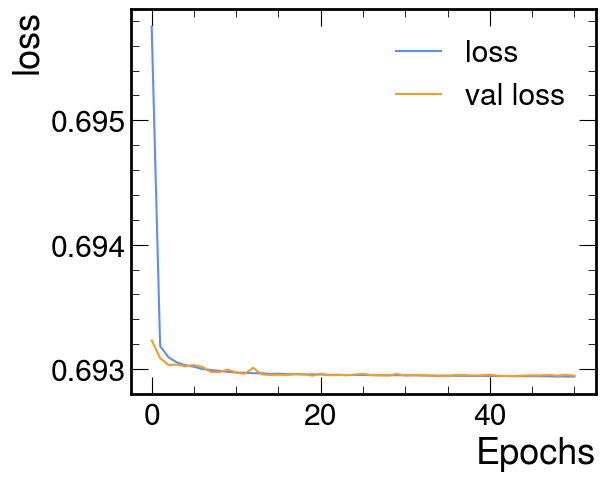

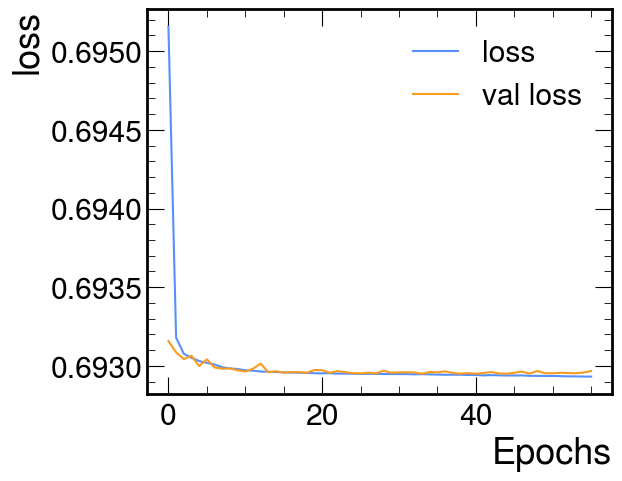

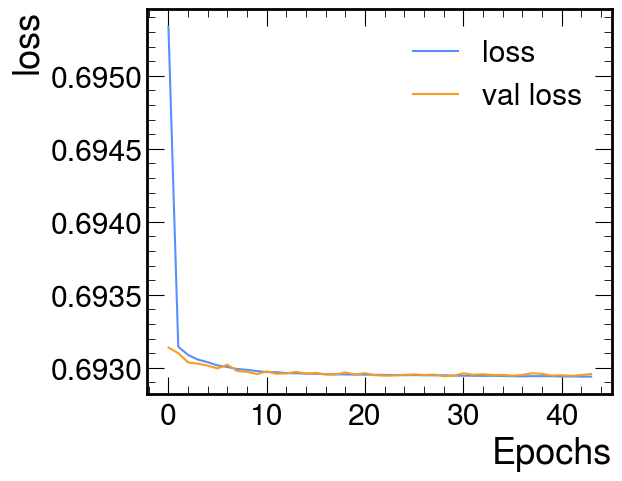

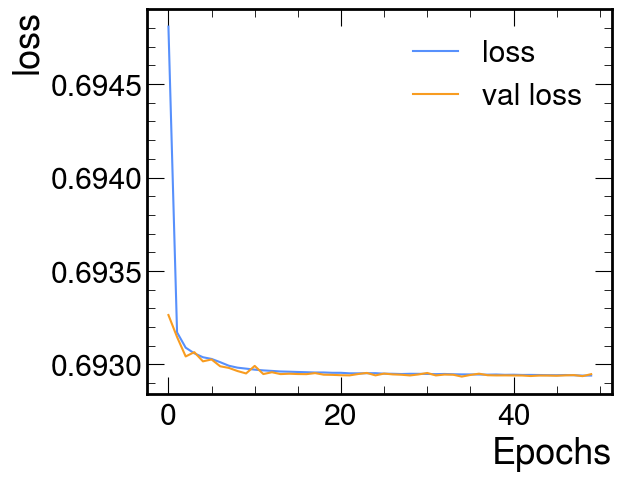

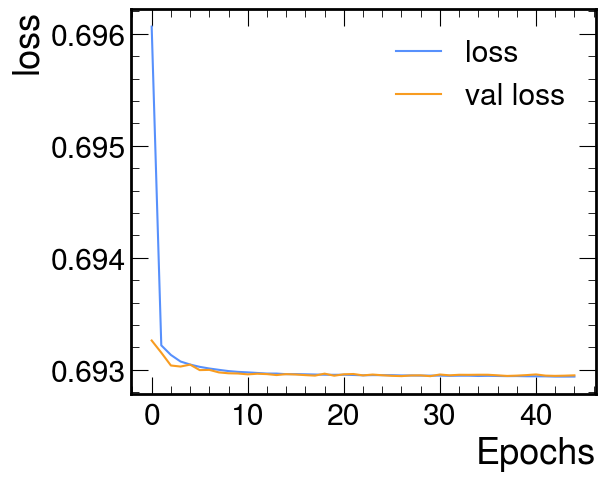

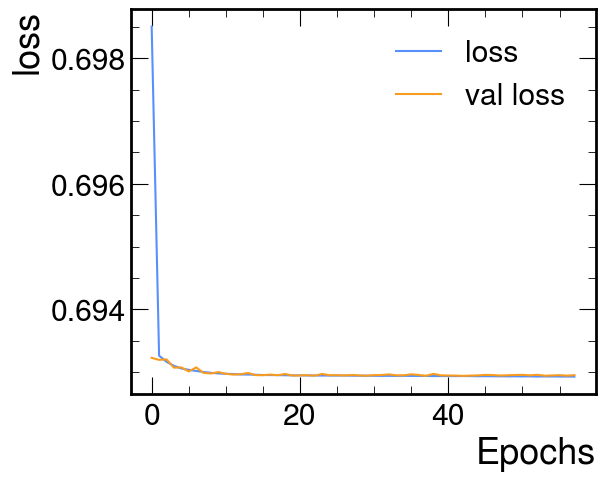

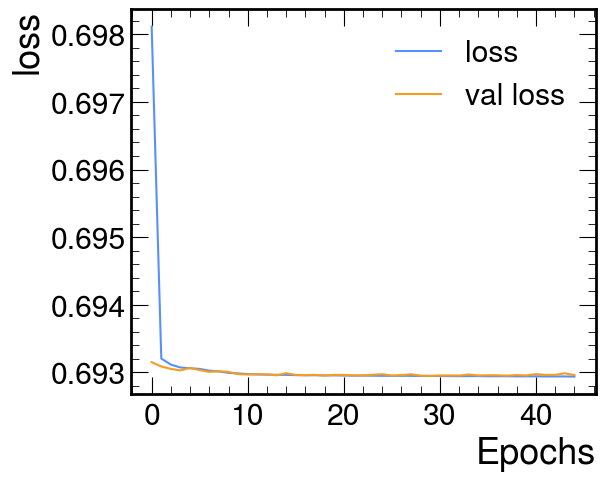

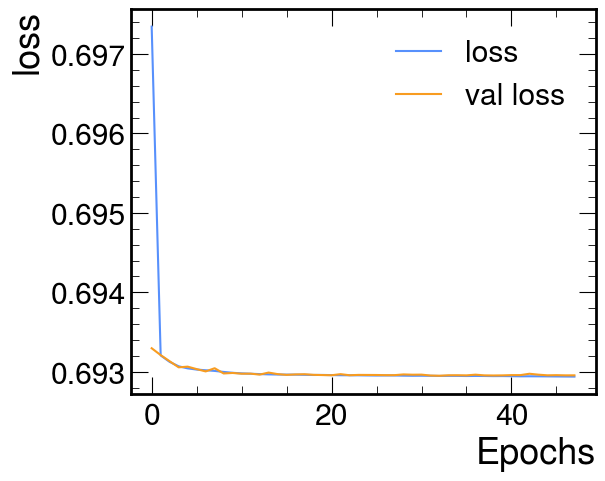

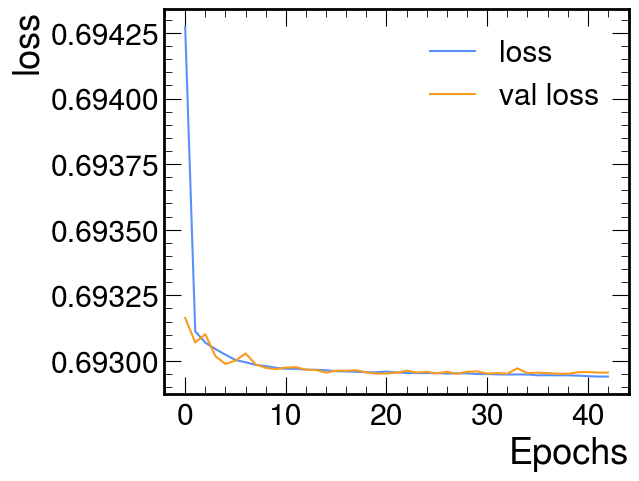

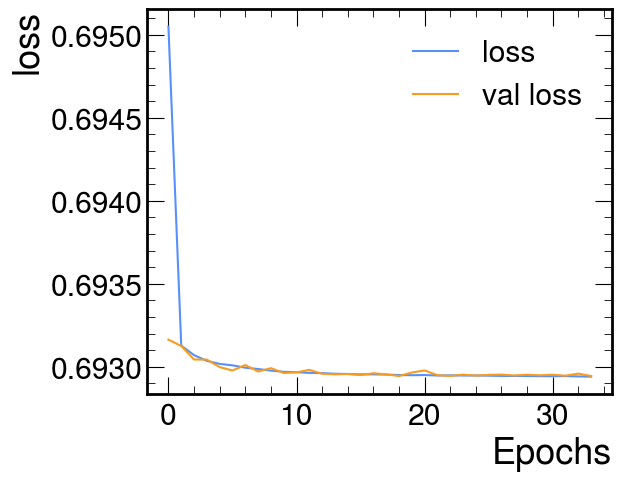

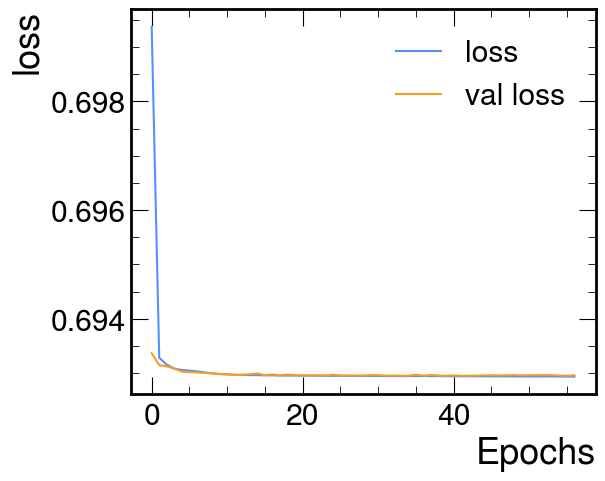

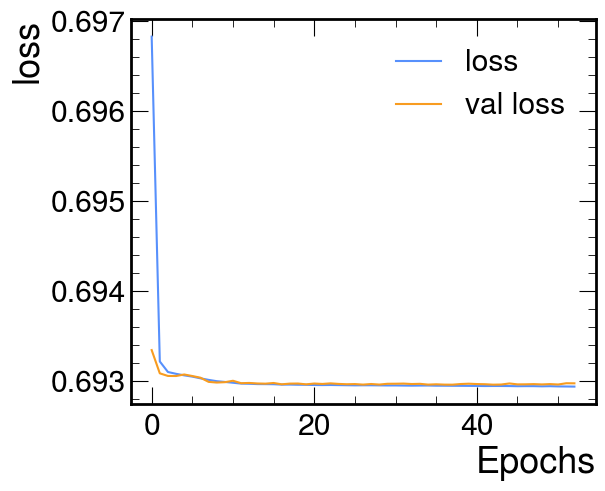

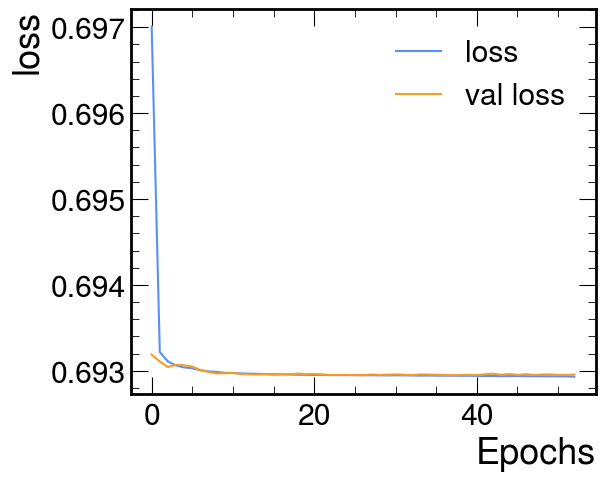

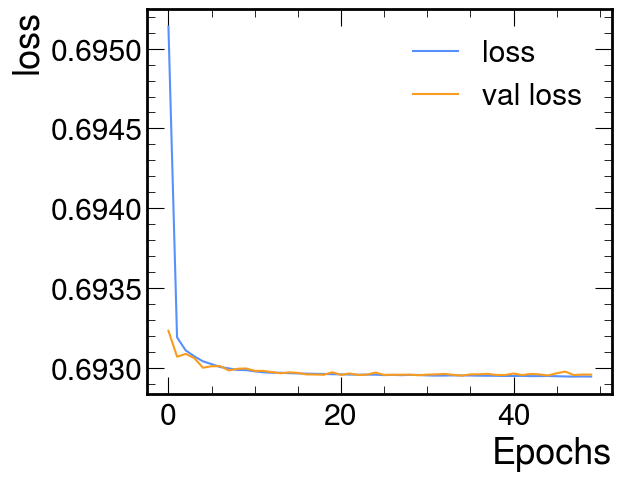

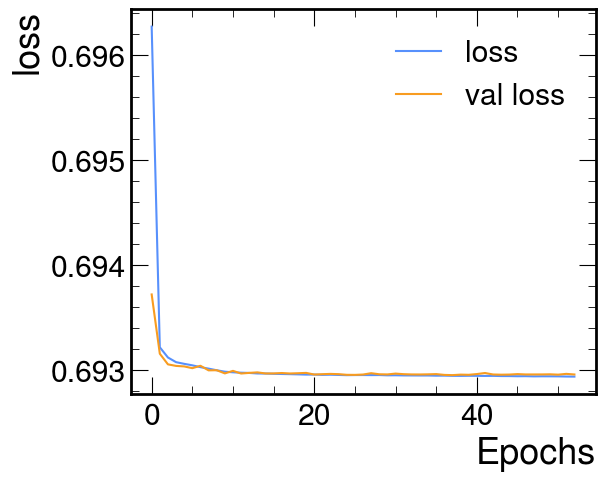

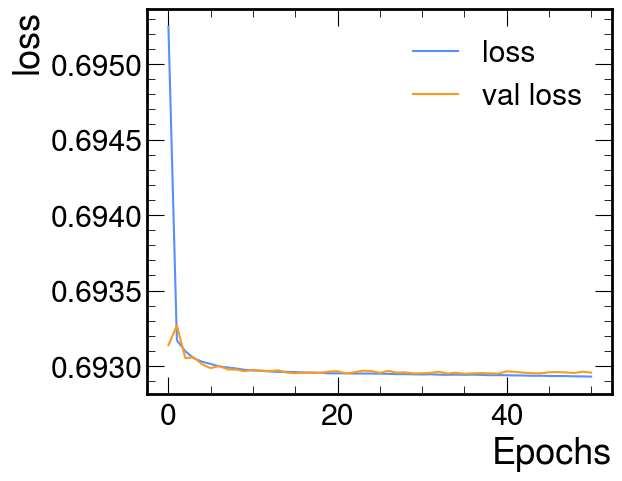

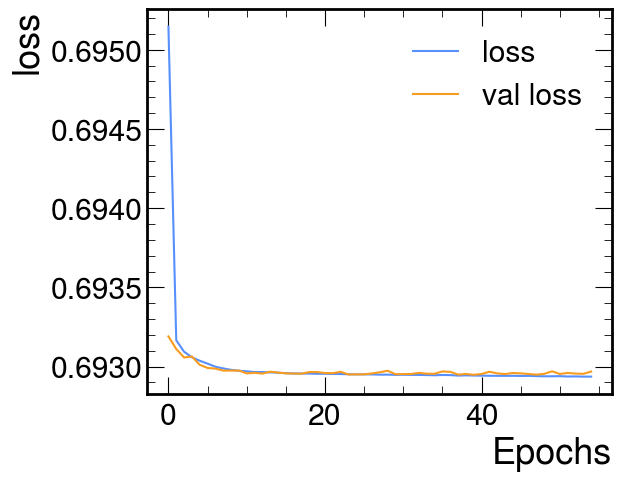

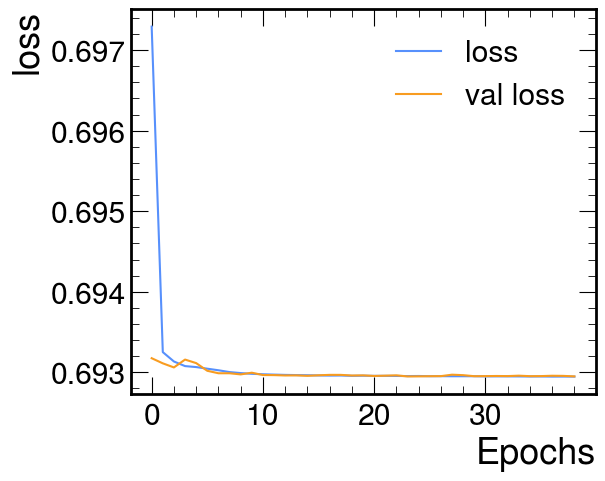

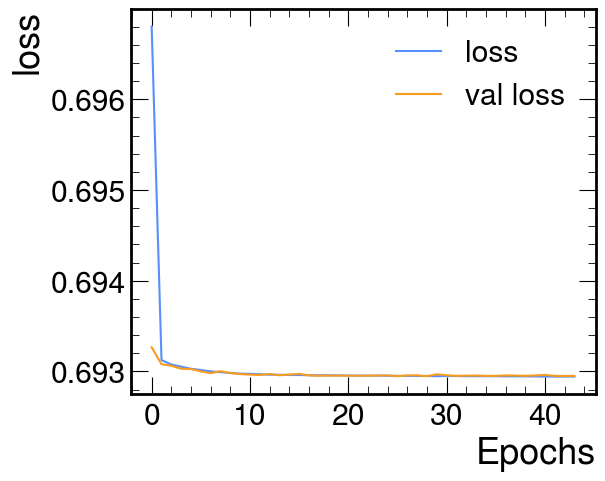

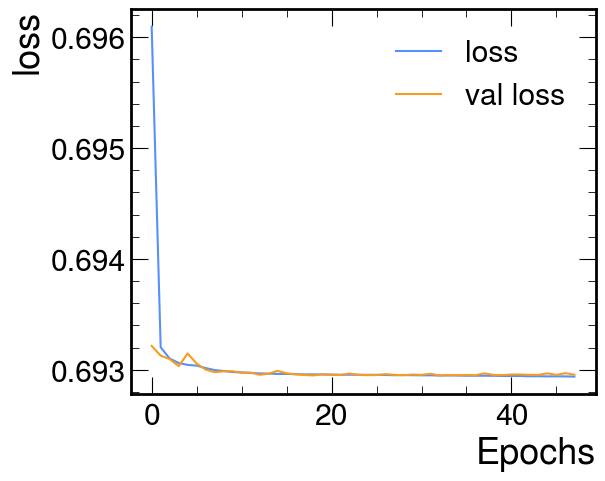

In [9]:
# train 20 iterations and save the model each time using the predefined functions
# taking 40 million random samples from each dataset (containing 99 million + events) for each iteration
'''
for i in range(1, 21):
    train_single_iteration(X0_nrm, X1_nrm, iteration=i)
'''    


Starting training
Epoch 1/1000
1460/1465 [============================>.] - ETA: 0s - loss: 0.6951 - acc: 0.5021
Epoch 1: val_loss improved from inf to 0.69326, saving model to ./saved_models/DCTR_training_iter_21.h5
1465/1465 [==============================] - 21s 12ms/step - loss: 0.6951 - acc: 0.5021 - val_loss: 0.6933 - val_acc: 0.5028
Epoch 2/1000
1465/1465 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.5033
Epoch 2: val_loss improved from 0.69326 to 0.69314, saving model to ./saved_models/DCTR_training_iter_21.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6932 - acc: 0.5033 - val_loss: 0.6931 - val_acc: 0.5041
Epoch 3/1000
1465/1465 [==============================] - ETA: 0s - loss: 0.6931 - acc: 0.5042
Epoch 3: val_loss improved from 0.69314 to 0.69307, saving model to ./saved_models/DCTR_training_iter_21.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6931 - acc: 0.5042 - val_loss: 0.6931 - val_acc: 0.5051
Ep

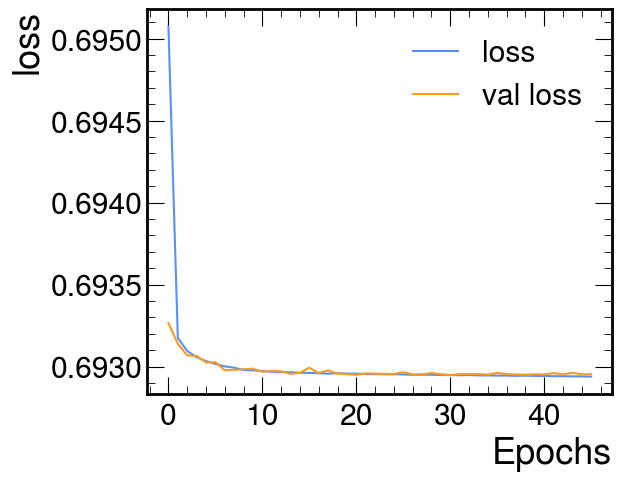

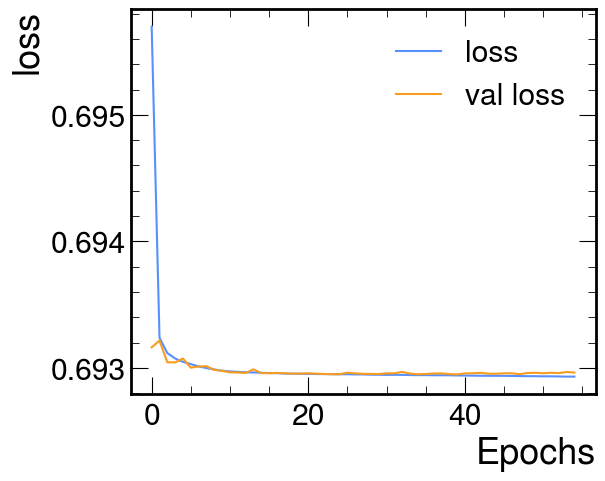

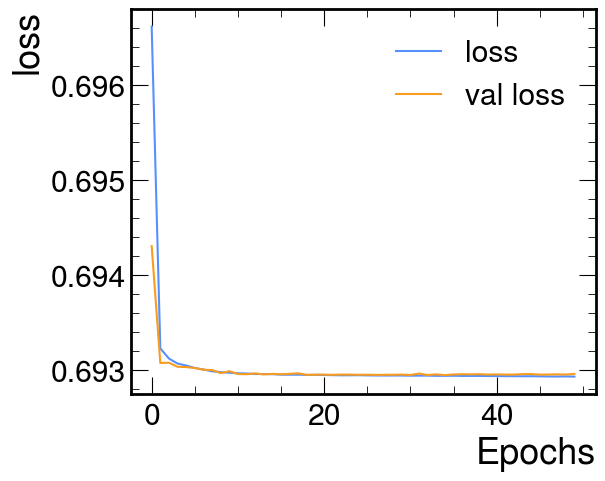

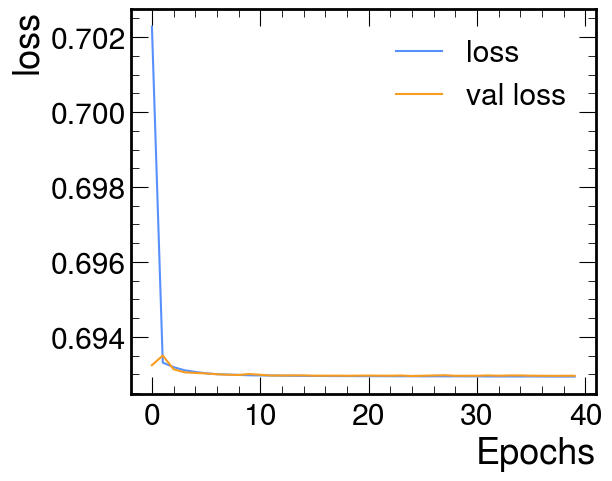

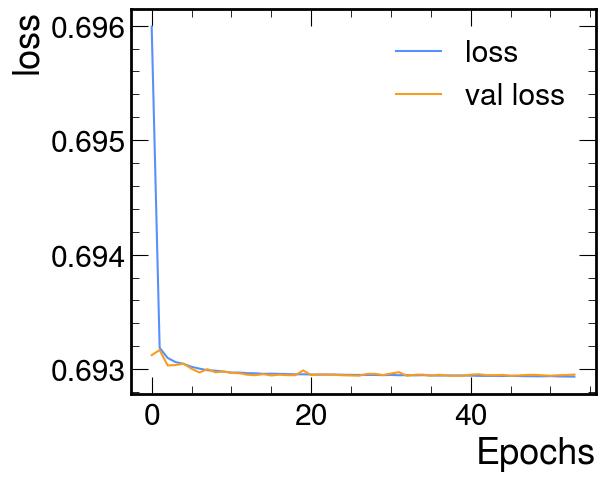

In [10]:
# walking the dog, so I have time for some more iterations

# train 5 more iterations and save the model each time using the predefined functions
# taking 40 million random samples from each dataset (containing 99 million + events) for each iteration
'''
for i in range(21, 26):
    train_single_iteration(X0_nrm, X1_nrm, iteration=i)
'''    


In [ ]:
# 25 more iterations to get a full 50
'''
for i in range(26, 51):
    train_single_iteration(X0_nrm, X1_nrm, iteration=i)
'''

2024-06-15 09:48:26.874841: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 09:48:26.877024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-15 09:48:26.877479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-15 09:48:26.877682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Starting training


2024-06-15 09:48:27.780983: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.
2024-06-15 09:48:28.485518: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.


Epoch 1/1000
1465/1465 [==============================] - ETA: 0s - loss: 0.6964 - acc: 0.5020
Epoch 1: val_loss improved from inf to 0.69325, saving model to ./saved_models/DCTR_training_iter_26.h5
1465/1465 [==============================] - 21s 12ms/step - loss: 0.6964 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.5020
Epoch 2/1000
1464/1465 [============================>.] - ETA: 0s - loss: 0.6932 - acc: 0.5031
Epoch 2: val_loss improved from 0.69325 to 0.69311, saving model to ./saved_models/DCTR_training_iter_26.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6932 - acc: 0.5031 - val_loss: 0.6931 - val_acc: 0.5034
Epoch 3/1000
1464/1465 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5040
Epoch 3: val_loss improved from 0.69311 to 0.69307, saving model to ./saved_models/DCTR_training_iter_26.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6931 - acc: 0.5040 - val_loss: 0.6931 - val_acc: 0.5056
Epoch 4/1000
1461/14

2024-06-15 09:59:49.745002: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.
2024-06-15 09:59:50.433503: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.


Epoch 1/1000
1460/1465 [============================>.] - ETA: 0s - loss: 0.6965 - acc: 0.5026
Epoch 1: val_loss improved from inf to 0.69311, saving model to ./saved_models/DCTR_training_iter_27.h5
1465/1465 [==============================] - 20s 12ms/step - loss: 0.6965 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5042
Epoch 2/1000
1465/1465 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.5034
Epoch 2: val_loss did not improve from 0.69311
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6932 - acc: 0.5034 - val_loss: 0.6931 - val_acc: 0.5047
Epoch 3/1000
1461/1465 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5042
Epoch 3: val_loss did not improve from 0.69311
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6931 - acc: 0.5042 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4/1000
1461/1465 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5047
Epoch 4: val_loss improved from 0.69311 to 0.69

2024-06-15 10:12:00.754922: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2880000000 exceeds 10% of free system memory.


Epoch 1/1000
1461/1465 [============================>.] - ETA: 0s - loss: 0.6958 - acc: 0.5022
Epoch 1: val_loss improved from inf to 0.69321, saving model to ./saved_models/DCTR_training_iter_28.h5
1465/1465 [==============================] - 21s 13ms/step - loss: 0.6958 - acc: 0.5022 - val_loss: 0.6932 - val_acc: 0.5039
Epoch 2/1000
1464/1465 [============================>.] - ETA: 0s - loss: 0.6932 - acc: 0.5030
Epoch 2: val_loss improved from 0.69321 to 0.69313, saving model to ./saved_models/DCTR_training_iter_28.h5
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6932 - acc: 0.5030 - val_loss: 0.6931 - val_acc: 0.5027
Epoch 3/1000
1461/1465 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5040
Epoch 3: val_loss did not improve from 0.69313
1465/1465 [==============================] - 18s 12ms/step - loss: 0.6931 - acc: 0.5040 - val_loss: 0.6932 - val_acc: 0.5046
Epoch 4/1000
1465/1465 [==============================] - ETA: 0s - loss: 0.6931 

In [ ]:
# 25 iterations with 80M random samples per iter

for i in range(1, 26):
    train_single_iteration(X0_nrm, X1_nrm, iteration=i, num_events = int(8e7), save_label = 'DCTR_training_80M')


2024-06-15 16:42:00.551409: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11520000000 exceeds 10% of free system memory.
2024-06-15 16:42:25.377213: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3840000000 exceeds 10% of free system memory.


Starting training
Epoch 1/1000
2927/2930 [============================>.] - ETA: 0s - loss: 0.6938 - acc: 0.5029
Epoch 1: val_loss improved from inf to 0.69307, saving model to ./saved_models/DCTR_training_80M_iter_01.h5
2930/2930 [==============================] - 42s 13ms/step - loss: 0.6938 - acc: 0.5030 - val_loss: 0.6931 - val_acc: 0.5034
Epoch 2/1000
2928/2930 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5048
Epoch 2: val_loss improved from 0.69307 to 0.69305, saving model to ./saved_models/DCTR_training_80M_iter_01.h5
2930/2930 [==============================] - 37s 12ms/step - loss: 0.6931 - acc: 0.5048 - val_loss: 0.6931 - val_acc: 0.5041
Epoch 3/1000
2927/2930 [============================>.] - ETA: 0s - loss: 0.6930 - acc: 0.5060
Epoch 3: val_loss improved from 0.69305 to 0.69299, saving model to ./saved_models/DCTR_training_80M_iter_01.h5
2930/2930 [==============================] - 37s 13ms/step - loss: 0.6930 - acc: 0.5060 - val_loss: 0.6930 - val_ac

2024-06-15 17:29:07.240053: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11520000000 exceeds 10% of free system memory.
2024-06-15 17:29:08.673739: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3840000000 exceeds 10% of free system memory.


Starting training
Epoch 1/1000
2927/2930 [============================>.] - ETA: 0s - loss: 0.6938 - acc: 0.5029
Epoch 1: val_loss improved from inf to 0.69315, saving model to ./saved_models/DCTR_training_80M_iter_02.h5
2930/2930 [==============================] - 41s 12ms/step - loss: 0.6938 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.5048
Epoch 2/1000
2929/2930 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5051
Epoch 2: val_loss improved from 0.69315 to 0.69301, saving model to ./saved_models/DCTR_training_80M_iter_02.h5
2930/2930 [==============================] - 36s 12ms/step - loss: 0.6931 - acc: 0.5051 - val_loss: 0.6930 - val_acc: 0.5061
Epoch 3/1000
2927/2930 [============================>.] - ETA: 0s - loss: 0.6930 - acc: 0.5061
Epoch 3: val_loss improved from 0.69301 to 0.69300, saving model to ./saved_models/DCTR_training_80M_iter_02.h5
2930/2930 [==============================] - 36s 12ms/step - loss: 0.6930 - acc: 0.5061 - val_loss: 0.6930 - val_ac